In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltimport 
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion
from lib.data import TwoStateMNISTData
from lib.utils import random_split_dataset

In [2]:
root = './mnist_data'
use_gpu = None # select a gpu
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
trainval_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
train_proportion = 0.8
train_set, val_set = random_split_dataset(trainval_set, [train_proportion, 1-train_proportion])
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [3]:
#sample n_samples correctly classified examples
def getCorrect(net, data, n_samples=100):
    xs = []
    ys = []

    i = 0
    while i < n_samples:
        d = data.next_batch(batch_size=1)
        x, y = d[0], d[1]
        output = net.eval_forward(*d)
        _, ans = torch.max(output, 1)
        if ans.item() != y.item(): # incorrect
            continue

        xs.append(x)
        ys.append(y)
        i += 1
    return xs, ys

def show_examples(net, xs, ys, n_show=3):
    for x, y in zip(xs[:n_show], ys[:n_show]):
        yhat = net.eval_forward(x, y, [len(x)])
        val, ind = torch.max(yhat, 1)
        
        n_images, _, w_h = x.shape
        print('label: %d, predict: %d, prob: %.2f' % (y.item(), ind.item(), np.exp(val.item())))
        for i in range(n_images):
            plt.subplot(1,3,i+1)
            plt.imshow(x[i].view(28,28).detach().numpy())
        plt.show()

### MLP: sanity check

In [13]:
from lib.model import MLP
net = MLP([784, 300, 10])
savename = 'models/mlp.pth.tar'
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = FlatData(train_set)

trainer = TrainMLP(net, optimizer, criterion, train_data, 
                   save_filename=savename, val_data=FlatData(val_set), use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/mlp.pth.tar'
=> loaded checkpoint 'models/mlp.pth.tar' (iteration 105)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
            124|             3%|          0m 0s|        0.00669|        0.00000|        0.56172
            155|             4%|          0m 0s|        0.00639|        0.00000|        0.54945
            186|             5%|          0m 0s|        0.00629|        0.00000|        0.50256
==> evaluating validation accuracy
==> validation accuracy is 87%
            217|             6%|          0m 2s|        0.00614|        0.00000|        0.49038
            248|             7%|          0m 2s|        0.00582|        0.00000|        0.47335
            279|             8%|          0m 2s|        0.00562|        0.00000|        0.46456
            310|             9%|          0m 2s|        0.00547|        0.00000|        0.45408
==> evaluating validation accuracy
==> validation accuracy is 89%

==> evaluating validation accuracy
==> validation accuracy is 95%
           2294|            73%|         0m 40s|        0.00496|        0.00000|        0.27213
           2325|            74%|         0m 40s|        0.00496|        0.00000|        0.27053
           2356|            75%|         0m 40s|        0.00495|        0.00000|        0.26906
           2387|            76%|         0m 40s|        0.00495|        0.00000|        0.26788
==> evaluating validation accuracy
==> validation accuracy is 95%
           2418|            77%|         0m 42s|        0.00498|        0.00000|        0.26633
           2449|            78%|         0m 43s|        0.00497|        0.00000|        0.26448
           2480|            79%|         0m 43s|        0.00497|        0.00000|        0.26346
==> evaluating validation accuracy
==> validation accuracy is 95%
           2511|            80%|         0m 44s|        0.00496|        0.00000|        0.26245
           2542|            81%|  

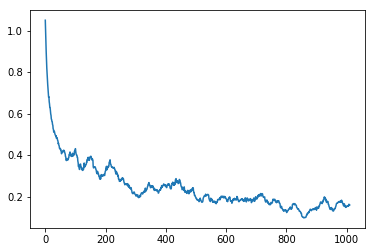

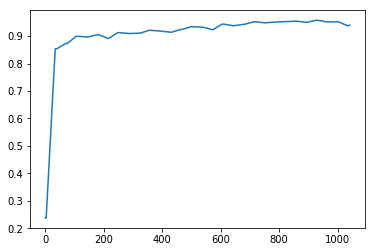

In [14]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

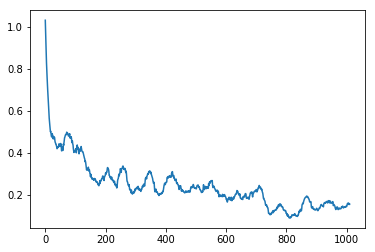

In [125]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 95.50%


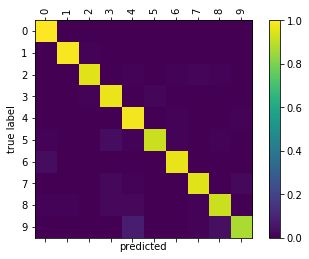

In [17]:
n_categories = 10
evaluation = Evaluation(net, FlatData(test_set), use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

# Sequence task: 1-3 mnist digits addition mod 10 (one output for seq)

### 2 layer MLP on the last step

In [18]:
from lib.model import RNN_MLP, RNN_Memoryless
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_MLP(784, n_hidden, n_categories)
savename = 'so_models/rnn_mlp.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)


trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename, val_data=val_data,
                     use_gpu=None)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 9%
             31|             0%|          0m 3s|        0.01297|        0.00000|        2.32213
             62|             1%|          0m 4s|        0.01227|        0.00000|        2.26038
             93|             2%|          0m 4s|        0.01209|        0.00000|        2.24900
==> evaluating validation accuracy
==> validation accuracy is 26%
            124|             3%|          0m 7s|        0.01200|        0.00000|        2.23744
            155|             4%|          0m 8s|        0.01193|        0.00000|        2.23079
            186|             5%|          0m 8s|        0.01187|        0.00000|        2.22381
==> evaluating validation accuracy
==> validation accuracy is 28%
            217|             6%|         0m 11s|        0.01183|        0.00000|        2.21445
            248|             7%|   

==> evaluating validation accuracy
==> validation accuracy is 32%
           2201|            70%|         1m 38s|        0.01441|        0.00000|        2.15387
           2232|            71%|         1m 38s|        0.01449|        0.00000|        2.15374
           2263|            72%|         1m 39s|        0.01460|        0.00000|        2.15332
==> evaluating validation accuracy
==> validation accuracy is 32%
           2294|            73%|         1m 43s|        0.01463|        0.00000|        2.15260
           2325|            74%|         1m 43s|        0.01460|        0.00000|        2.15257
           2356|            75%|         1m 43s|        0.01457|        0.00000|        2.15249
           2387|            76%|         1m 44s|        0.01458|        0.00000|        2.15203
==> evaluating validation accuracy
==> validation accuracy is 32%
           2418|            77%|         1m 47s|        0.01463|        0.00000|        2.15193
           2449|            78%|  

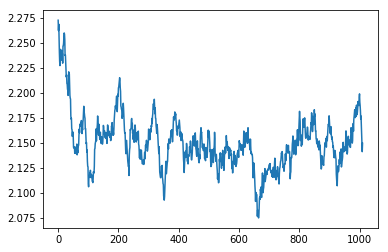

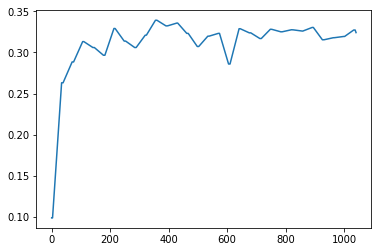

In [19]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

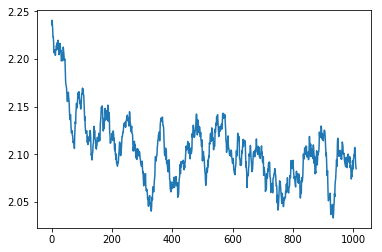

In [127]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 75.90%


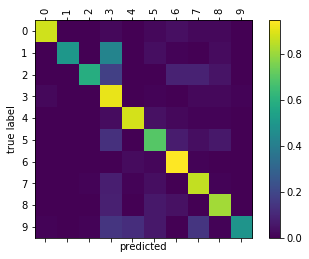

In [22]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### IMLP

In [39]:
from lib.model import RNN_IMLP
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_IMLP(784, n_hidden, n_categories)
savename = 'so_models/rnn_imlp.pth.tar'
net.set_max_length(3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename, val_data=val_data,
                     use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'so_models/rnn_imlp.pth.tar'
=> loaded checkpoint 'so_models/rnn_imlp.pth.tar' (iteration 1353)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
           1364|            43%|          0m 0s|        0.02546|        0.00000|        1.67556
           1395|            44%|          0m 0s|        0.02224|        0.00000|        1.67227
           1426|            45%|          0m 1s|        0.02429|        0.00000|        1.67086
           1457|            46%|          0m 2s|        0.02453|        0.00000|        1.68082
           1488|            47%|          0m 3s|        0.02556|        0.00000|        1.68306
           1519|            48%|          0m 4s|        0.02615|        0.00000|        1.68435
           1550|            49%|          0m 5s|        0.02651|        0.00000|        1.68763
==> evaluating validation accuracy
==> validation accuracy is 34%
           1581|            50%|         0m 13s|

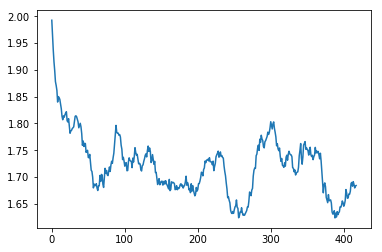

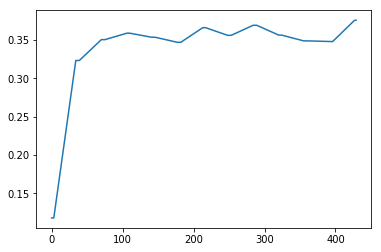

In [28]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

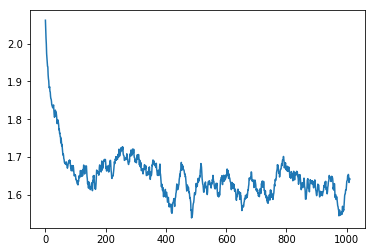

In [129]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.60%


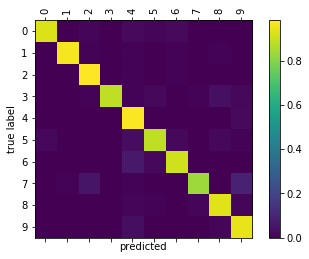

In [73]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### SMLP

In [29]:
from lib.model import RNN_SMLP

n_hidden = 300
n_categories = 10
net = RNN_SMLP(784, n_hidden, n_categories)
savename = 'so_models/rnn_smlp.pth.tar'
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename, val_data=val_data,
                     use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_smlp.pth.tar'
=> loaded checkpoint 'models/rnn_smlp.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


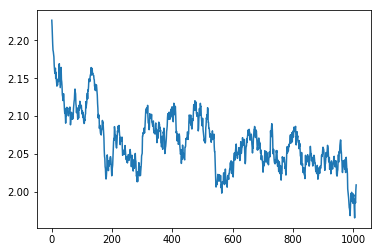

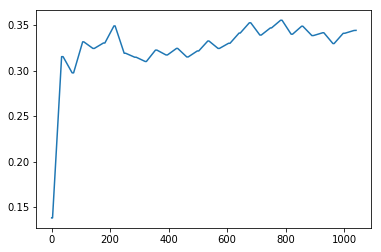

In [30]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

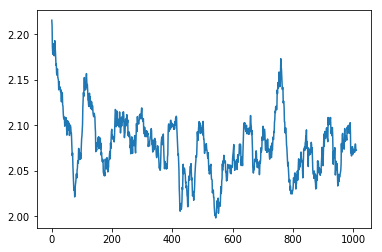

In [10]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.00%


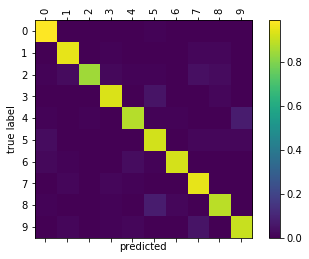

In [24]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Independent LSTM (each time step uses an independent LSTM cell)

In [4]:
from lib.model import RNN_ILSTM
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_ILSTM(784, n_hidden, n_categories)
savename = 'so_models/rnn_ilstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 10%
             31|             0%|          0m 9s|        0.03348|        0.00000|        2.26049
             62|             1%|         0m 10s|        0.03350|        0.00000|        2.10920
             93|             2%|         0m 11s|        0.03268|        0.00000|        2.00091
            124|             3%|         0m 12s|        0.03240|        0.00000|        1.93126
            155|             4%|         0m 13s|        0.03217|        0.00000|        1.88765
            186|             5%|         0m 14s|        0.03216|        0.00000|        1.85724
            217|             6%|         0m 15s|        0.03190|        0.00000|        1.83992
            248|             7%|         0m 16s|        0.03193|        0.00000|        1.82216
            279|             8%|         0m 17s|        0.03195|      

           2480|            79%|         2m 34s|        0.03115|        0.00000|        1.39156
==> evaluating validation accuracy
==> validation accuracy is 37%
           2511|            80%|         2m 45s|        0.03116|        0.00000|        1.38889
           2542|            81%|         2m 46s|        0.03115|        0.00000|        1.38591
           2573|            82%|         2m 47s|        0.03115|        0.00000|        1.38357
           2604|            83%|         2m 47s|        0.03115|        0.00000|        1.38084
           2635|            84%|         2m 48s|        0.03115|        0.00000|        1.37847
           2666|            85%|         2m 49s|        0.03115|        0.00000|        1.37585
           2697|            86%|         2m 50s|        0.03115|        0.00000|        1.37263
           2728|            87%|         2m 51s|        0.03114|        0.00000|        1.36928
           2759|            88%|         2m 52s|        0.03115|      

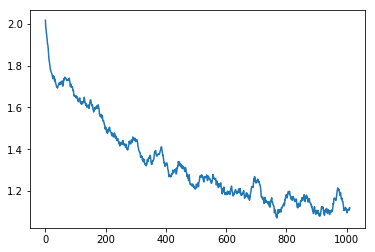

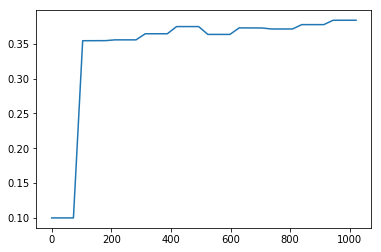

In [5]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

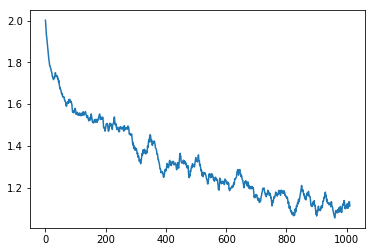

In [133]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.40%


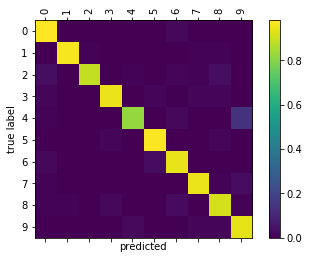

In [38]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Staged LSTM

In [6]:
from lib.model import RNN_SLSTM

n_hidden = 300
n_categories = 10
net = RNN_SLSTM(784, n_hidden, n_categories)
savename = 'so_models/rnn_slstm.pth.tar'
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename, val_data=val_data,
                     use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss
==> evaluating validation accuracy
==> validation accuracy is 8%
             31|             0%|         0m 10s|        0.03014|        0.00000|        2.27495
             62|             1%|         0m 11s|        0.03012|        0.00000|        2.20631
             93|             2%|         0m 11s|        0.03014|        0.00000|        2.15428
            124|             3%|         0m 12s|        0.03008|        0.00000|        2.09062
            155|             4%|         0m 13s|        0.03011|        0.00000|        2.03000
            186|             5%|         0m 14s|        0.03010|        0.00000|        1.97902
            217|             6%|         0m 15s|        0.03006|        0.00000|        1.93245
            248|             7%|         0m 16s|        0.03007|        0.00000|        1.89550
            279|             8%|         0m 17s|        0.03009|       

           2480|            79%|         2m 29s|        0.03023|        0.00000|        1.33448
==> evaluating validation accuracy
==> validation accuracy is 37%
           2511|            80%|         2m 39s|        0.03027|        0.00000|        1.33126
           2542|            81%|         2m 40s|        0.03027|        0.00000|        1.32844
           2573|            82%|         2m 41s|        0.03026|        0.00000|        1.32536
           2604|            83%|         2m 41s|        0.03025|        0.00000|        1.32255
           2635|            84%|         2m 42s|        0.03024|        0.00000|        1.32047
           2666|            85%|         2m 43s|        0.03024|        0.00000|        1.31751
           2697|            86%|         2m 44s|        0.03024|        0.00000|        1.31441
           2728|            87%|         2m 45s|        0.03023|        0.00000|        1.31107
           2759|            88%|         2m 46s|        0.03022|      

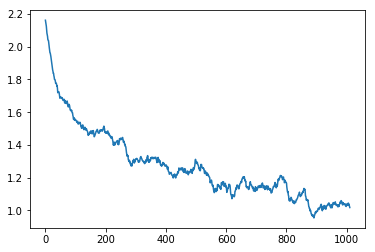

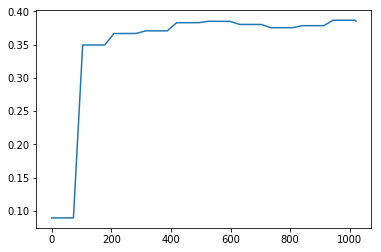

In [7]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

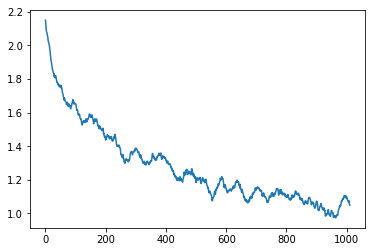

In [135]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.50%


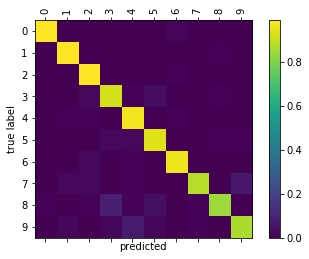

In [57]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### LSTM

In [8]:
from lib.model import RNN_LSTM
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_LSTM(784, n_hidden, n_categories)
savename = 'so_models/rnn_lstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, 
                     save_filename=savename, val_data=val_data, use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_lstm.pth.tar'
=> loaded checkpoint 'models/rnn_lstm.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


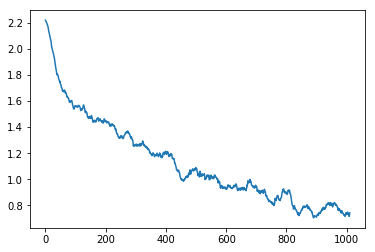

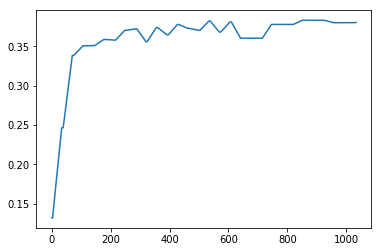

In [9]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

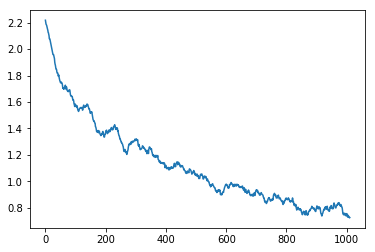

In [191]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.80%


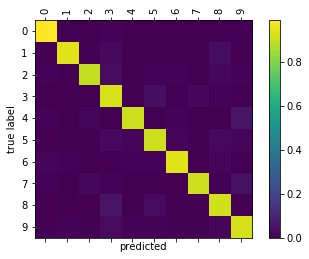

In [157]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

label: 9, predict: 9, prob: 0.70


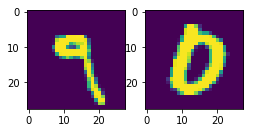

label: 6, predict: 6, prob: 0.44


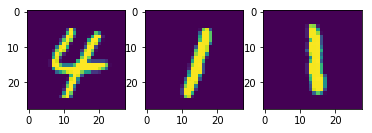

label: 8, predict: 8, prob: 0.23


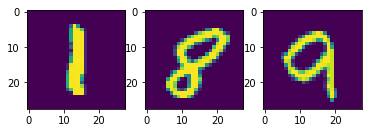

In [27]:
xs, ys = getCorrect(net, MNIST_add_data(test_set, min_length=2, max_length=3))    
show_examples(net, xs, ys)

### proposed methods: Mixture of Weights

$$W_t = \sum_{k=1}^K \lambda^{(k)}_t W^{(k)}$$ 


### lstm mow

In [16]:
from lib.model import RNN_LSTM_MoW
from lib.train import TrainSORNN

n_hidden = 300
n_categories = 10
net = RNN_LSTM_MoW(784, n_hidden, n_categories)
savename = 'so_models/rnn_lstm_mow.pth.tar'
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)
val_data = MNIST_add_data(train_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename, val_data=val_data, 
                    use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_lstm_mow.pth.tar'
=> loaded checkpoint 'models/rnn_lstm_mow.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


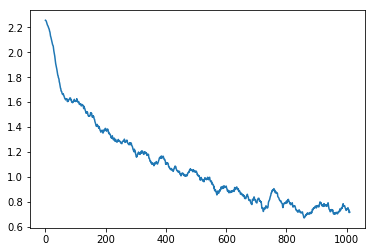

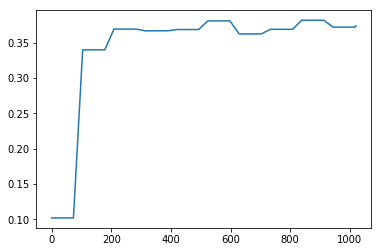

In [17]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

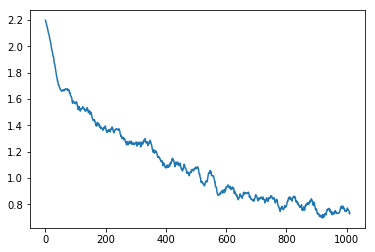

In [139]:
plt.plot(trainer.smooth_loss())
plt.show()

/data/jiaxuan/sequence_fun/lib/model.py:46: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  o, hidden = self.model(x, hidden)


accuracy is 93.90%


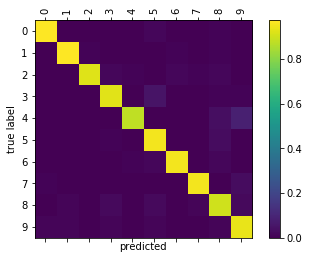

In [18]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

## mlp mow

In [20]:
from lib.model import RNN_MLP_MoW

n_hidden = 300
n_categories = 10
net = RNN_MLP_MoW(784, n_hidden, n_categories)
savename = 'so_models/rnn_mlp_mow.pth.tar'
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()

train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)
val_data = MNIST_add_data(val_set)
val_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainSORNN(net, optimizer, criterion, train_data, save_filename=savename, val_data=val_data,
                    use_gpu=use_gpu)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_mlp_mow.pth.tar'
=> loaded checkpoint 'models/rnn_mlp_mow.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


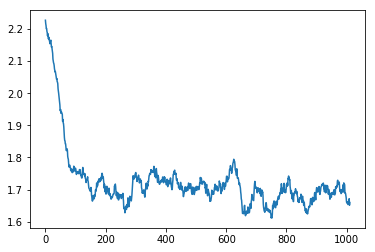

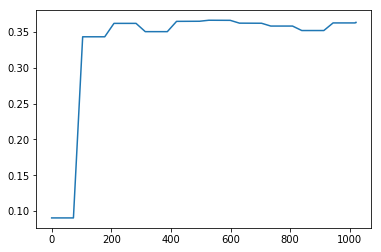

In [ ]:
plt.plot(trainer.smooth_loss())
plt.show()

plt.plot(trainer.smooth_valacc())
plt.show()

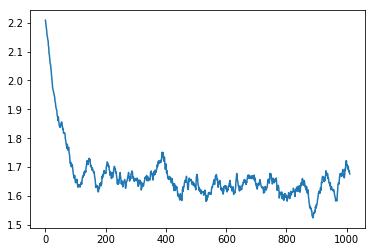

In [141]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 89.10%


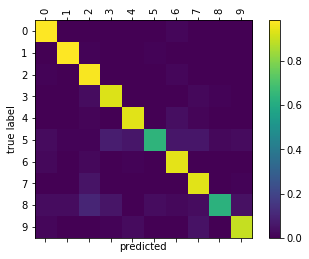

In [21]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data, use_gpu=use_gpu)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

In [22]:
torch.nn.functional.softmax(net.coef, 1)

tensor([[0.1893, 0.8107],
        [0.6310, 0.3690],
        [0.6282, 0.3718]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### curves on the same plot

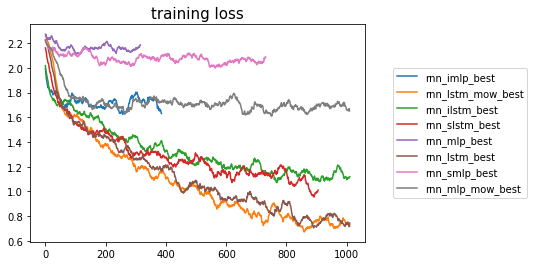

In [34]:
import glob
from lib.train import Train

dummy_trainer = Train(None, None, None, None)
for cpt_fn in glob.glob("so_models/*_best*"):
    cpt = torch.load(cpt_fn)
    name = cpt_fn.split('.')[0].split('/')[-1]
    l = cpt['train_losses']
    dummy_trainer.all_losses = l
    plt.plot(dummy_trainer.smooth_loss(), label=name)

plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('training loss', fontsize=15)
plt.show()

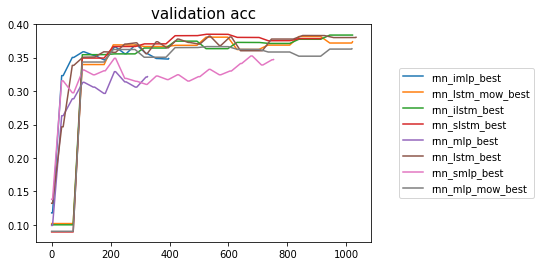

In [37]:
import glob
from lib.train import Train

dummy_trainer = Train(None, None, None, None)
for cpt_fn in glob.glob("so_models/*_best*"):
    cpt = torch.load(cpt_fn)
    name = cpt_fn.split('.')[0].split('/')[-1]
    l = cpt['val_accs']
    dummy_trainer.val_accs = l
    plt.plot(dummy_trainer.smooth_valacc(), label=name)

plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('validation acc', fontsize=15)
plt.show()

## Prediction tasks associated with internal states

Consider the following problem

$\mathcal{S} = \{s1, s2\}$

$\mathcal{X} = \text{MNIST Digits}$

Prediction function $f$ 

$f: x \mapsto x$ if $s=s1$

$f: x \mapsto {10-x} \pmod{10}$ if $s=s2$

State transition is **independent** of covariates at the current time step

$p(s_{t+1} = s1|s_t=s1) = p$

$p(s_{t+1} = s2|s_t=s2) = 1$

$p(s_0=s1) = 1$

In other words, we starts at state $s1$ and transition to $s2$ with probability $(1-p)$, and once we are at $s2$, we never look back.


In [222]:
p = 0.1
n_time_steps = 8

print('p=%.2f' % p)
header = ('t', 'P(s1)', 'P(s2)')
columns = []
columns.append(header)
for i in range(n_time_steps):
    columns.append((i, p**i, 1-p**i))
    
def print_table(columns):
    def format(x):
        if type(x) is float:
            x_tr = "%.3f" % x
        else:
            x_tr = str(x)
        return "%10s" % x_tr

    to_print = ""
    for r in zip(*columns):
        r = map(format, r)
        to_print += " ".join(r)
        to_print += "\n"
    print(to_print)

print_table(columns)

p=0.10
         t          0          1          2          3          4          5          6          7
     P(s1)      1.000      0.100      0.010      0.001      0.000      0.000      0.000      0.000
     P(s2)      0.000      0.900      0.990      0.999      1.000      1.000      1.000      1.000

